# Logistic Regression Walkthrough — Titanic Dataset

In this notebook, we will build a logistic regression model to predict whether a passenger survived the Titanic disaster.

**Stages:**
1. Data Inspection (`.info()`, `.describe()`)
2. Exploratory Data Analysis (EDA)
3. Class Imbalance Check
4. Model Training
5. Prediction & Evaluation
6. ROC Curve & AUC Score
7. Interpretation of Results

## Imports

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
sns.set(style='whitegrid')

## Load the Titanic Dataset

In [21]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Step 1: Data Inspection

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [23]:
df.describe(include='all')

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889,891,891,891,203,889,891,891
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,3,3,2,7,3,2,2
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Third,man,True,C,Southampton,no,True
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,644,491,537,537,59,644,549,537
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 2: Exploratory Data Analysis (EDA)

We want to see which features correlate with survival.
- We'll look at sex, age, fare, and class.
- We'll also check for missing values and class imbalance.

In [24]:
# Drop rows with missing 'age' or 'sex'
df = df[['sex', 'age', 'fare', 'pclass', 'survived']].dropna()
df['sex'] = df['sex'].map({'male': 0, 'female': 1})

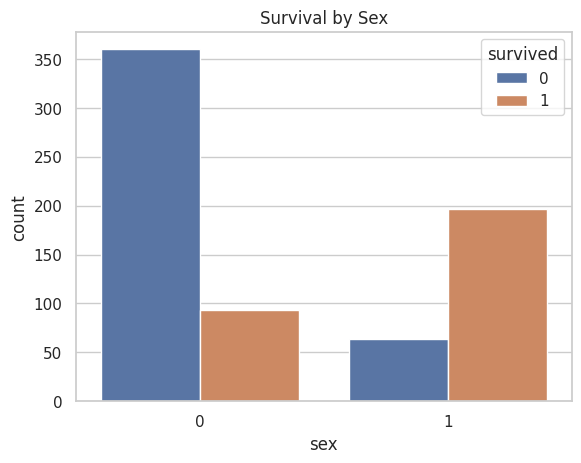

In [25]:
# Survival by sex
sns.countplot(x='sex', hue='survived', data=df)
plt.title('Survival by Sex')
plt.show()

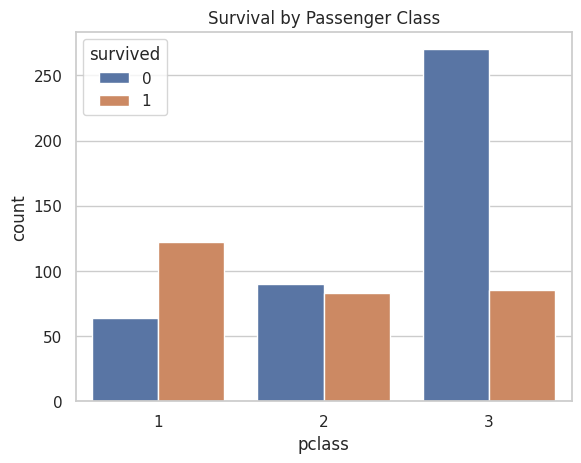

In [26]:
# Survival by class
sns.countplot(x='pclass', hue='survived', data=df)
plt.title('Survival by Passenger Class')
plt.show()

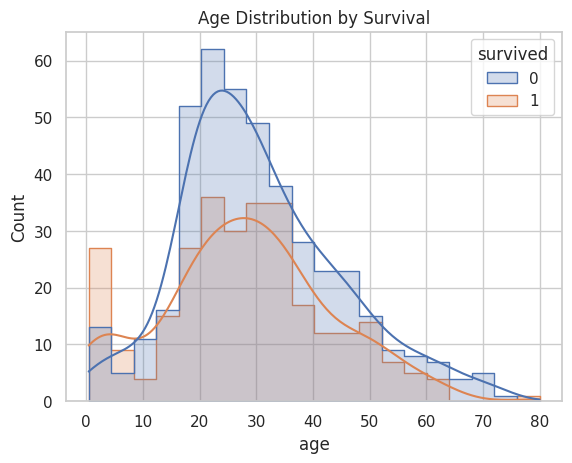

In [27]:
# Age distribution by survival
sns.histplot(data=df, x='age', hue='survived', kde=True, element='step')
plt.title('Age Distribution by Survival')
plt.show()

In [28]:
# Check for class imbalance
df['survived'].value_counts(normalize=True)

,proportion
survived,
0,0.593838
1,0.406162


## What Makes Logistic Regression Suitable?

Logistic regression assumes:
- A **binary target** variable (we have 'survived')
- A **linear relationship** between the log-odds of the target and the features
- Independence of observations
- Features should not be highly correlated (multicollinearity)
- No extreme outliers (they affect the log-odds linearly)

Our data appears compatible — we can now proceed to modeling.

## 🔧 Step 3: Train the Logistic Regression Model

In [29]:
X = df[['sex', 'age', 'fare']]
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [30]:
print('Intercept (b₀):', model.intercept_)
print('Coefficients (bᵢ):', model.coef_)

Intercept (b₀): [-1.1725499]
Coefficients (bᵢ): [[ 2.37028971 -0.01835573  0.01281015]]


### Formula Used

The logistic regression model computes a weighted linear combination of the input features, then applies the **sigmoid function** to convert it into a probability.

$z = b_0 + b_1 \cdot \text{sex} + b_2 \cdot \text{age} + b_3 \cdot \text{fare}$

$\hat{p} = \frac{1}{1 + e^{-z}}$

Where:

- $z$: linear score (log-odds)  
- $b_0$: intercept  
- $b_1, b_2, b_3$: learned coefficients  
- $\hat{p}$: predicted probability of survival  


**Decision Rule:**

- If $\hat{p} > 0.5$, classify as **survived**  
- If $\hat{p} \leq 0.5$, classify as **not survived**

## Step 4: Predict and Evaluate

In [31]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[69 18]
 [18 38]]
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        87
           1       0.68      0.68      0.68        56

    accuracy                           0.75       143
   macro avg       0.74      0.74      0.74       143
weighted avg       0.75      0.75      0.75       143



### What We’re Evaluating:

- **Confusion Matrix**: compares predicted vs actual outcomes
- **Precision**: how many predicted positives were correct
- **Recall**: how many actual positives were correctly predicted
- **F1 Score**: harmonic mean of precision and recall
- **Accuracy**: overall correctness — but beware of imbalance!

## Step 5: ROC Curve & AUC Score

The ROC Curve shows how well the model separates the classes across all thresholds.

**AUC (Area Under Curve)** indicates how likely the model ranks a random positive higher than a random negative:
- AUC = 0.5 → random guessing
- AUC = 1.0 → perfect separation

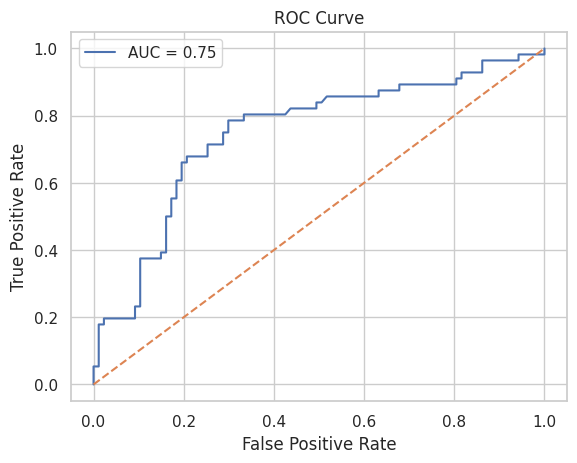

In [32]:
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

### ROC Curve and AUC Explained

#### What Is the ROC Curve?

The **ROC Curve** (Receiver Operating Characteristic curve) is a graphical plot that shows how a binary classifier performs across different classification thresholds.

Instead of fixing a cutoff at 0.5 (as we usually do in logistic regression), the ROC curve shows what happens if we slide the threshold from 0 to 1.

Each point on the ROC curve represents a different threshold and shows the tradeoff between:

- **True Positive Rate (TPR)** — also known as **Recall**  
  $$
  \text{TPR} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

- **False Positive Rate (FPR)**  
  $$
  \text{FPR} = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
  $$

#### What Does the Curve Tell Us?

- The **x-axis** is the **False Positive Rate**
- The **y-axis** is the **True Positive Rate**

A **perfect model** would reach the top-left corner:  
- TPR = 1 (all positives caught)  
- FPR = 0 (no false alarms)

A **random guesser** would produce a diagonal line from (0, 0) to (1, 1).

---

#### What Is AUC?

**AUC** stands for **Area Under the Curve** — specifically the ROC curve.

- AUC = 1.0 → perfect model  
- AUC = 0.5 → random chance (no predictive power)  
- AUC < 0.5 → worse than random (probably flipped labels)

AUC gives a **single-number summary** of how well the model distinguishes between the two classes across all thresholds.

---

#### Why ROC/AUC Is Useful

- It’s **threshold-independent** — shows overall model quality
- Helps compare models even when datasets are imbalanced
- Better than accuracy when class distribution is skewed

---

#### Key Takeaways

- Use ROC/AUC when you care about ranking predictions and understanding tradeoffs.
- AUC is a **global metric**, unlike precision or recall at one fixed threshold.
- A high AUC means the model is good at separating positives from negatives — regardless of the exact threshold.
- TPR (Recall): Of all actual positives, how many did we correctly identify?
- FPR: Of all actual negatives, how many did we incorrectly label as positive?

## Final Interpretation

- The logistic regression model learned how age, sex, and fare affect survival.
- The coefficients represent **log-odds**, but we often interpret them in terms of their **direction and strength**.
- ROC and AUC give us a **threshold-independent** view of the model.
- Accuracy is OK, but precision/recall matter more with imbalance.
- Next steps: try `pclass`, `embarked`, or regularization!